In [99]:
import random
from sklearn import preprocessing
import tensorflow.keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML


In [104]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [63]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 30,
        shear_range = 0.2,
        zoom_range = 0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip = True,
        fill_mode = 'nearest')

In [64]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

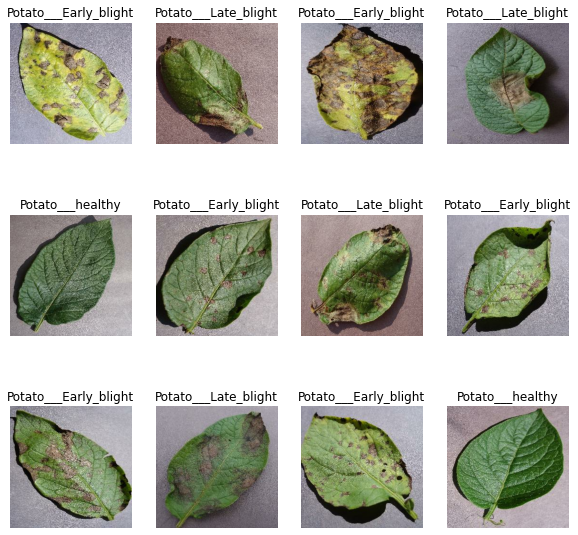

In [68]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
        

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [34]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
len(train_ds)


54

In [36]:
len(val_ds)


6

In [37]:
len(test_ds)

8

In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [39]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [47]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [79]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 246s 5s/step - loss: 0.4012 - accuracy: 0.8472 - val_loss: 0.1895 - val_accuracy: 0.9010
Epoch 2/10
54/54 [==============================] - 248s 5s/step - loss: 0.1523 - accuracy: 0.9387 - val_loss: 0.0734 - val_accuracy: 0.9740
Epoch 3/10
54/54 [==============================] - 220s 4s/step - loss: 0.0990 - accuracy: 0.9606 - val_loss: 0.0563 - val_accuracy: 0.9844
Epoch 4/10
54/54 [==============================] - 207s 4s/step - loss: 0.0465 - accuracy: 0.9809 - val_loss: 0.0623 - val_accuracy: 0.9792
Epoch 5/10
54/54 [==============================] - 207s 4s/step - loss: 0.0863 - accuracy: 0.9682 - val_loss: 0.0296 - val_accuracy: 0.9948
Epoch 6/10
54/54 [==============================] - 199s 4s/step - loss: 0.0348 - accuracy: 0.9855 - val_loss: 0.0614 - val_accuracy: 0.9792
Epoch 7/10
54/54 [==============================] - 220s 4s/step - loss: 0.0948 - accuracy: 0.9659 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 8/10
54

In [80]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 27s 4s/step - loss: 0.0511 - accuracy: 0.9805


In [81]:
scores


[0.05112762749195099, 0.98046875]

In [82]:
history


In [83]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [84]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [85]:
type(history.history['loss'])

list

In [95]:
len(history.history['loss'])

10

In [96]:
history.history['loss'][:5]

[0.4012380838394165,
 0.15231379866600037,
 0.09897800534963608,
 0.04645533114671707,
 0.0862991213798523]

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

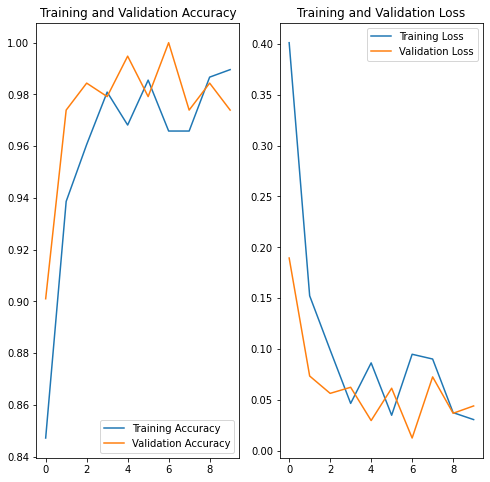

In [106]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [108]:
import os
model.save('final_model.h5')